https://github.com/comsa33/NLP-LSTM-emotion_classification/blob/main/N423a_Discussion2.ipynb

# 0) 모듈 실행

##기본 모듈

In [8]:
# Matplotlib 와 pandas 그래프에서 한글 사용 설정
import sys

## 노트북이 코랩에서 실행중인지 체크
if 'google.colab' in sys.modules:
  !echo 'debconf debconf/frontend select Noninterative' | debconf-set-selections
  ## 나눔 폰트 설치
  !sudo apt-get -qq -y install fonts-nanum
  import matplotlib.font_manager as fm
  font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
  for fpath in font_files:
    fm.fontManager.addfont(fpath)

  # 나눔바른고딕 폰트 설정
  import matplotlib.pyplot as plt
  plt.rc('font', family='NanumBarunGothic')
  # 마이너스 기호 표시 오류 수정
  import matplotlib
  matplotlib.rcParams['axes.unicode_minus'] = False


In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import random
import os

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
!pip install konlpy

In [11]:
import re
import urllib.request
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import Counter

In [12]:
from konlpy.tag import Okt

okt = Okt()

# 1) 데이터 가져오기

## 감성대화 말뭉치
https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=86
- 일반인 1,500명 대상의 인터뷰 및 크라우드 소싱 수행
- 우울증 환자 대상 WOZ 대화 수집

=> 전처리 과정으로 "한사람만의 대화를 줄글로 변형 - 질문 제거"

### 1. 데이터 가져오기

In [13]:
train = pd.read_excel("/content/drive/MyDrive/0000/Class/졸프/Dataset/AIhub_감성대화/Training_221115_add/원천데이터/감성대화말뭉치(최종데이터)_Training.xlsx")
test = pd.read_excel("/content/drive/MyDrive/0000/Class/졸프/Dataset/AIhub_감성대화/Validation_221115_add/원천데이터/감성대화말뭉치(최종데이터)_Validation.xlsx")

In [14]:
train_df = train.copy()
test_df = test.copy()

### 2. 전처리

In [15]:
# "사람문장3" 결측값 대체
train_df.fillna('',inplace=True)
test_df.fillna('',inplace=True)

# 문장 병합
train_df['사람문장'] = train_df['사람문장1']+train_df['사람문장2']+train_df['사람문장3']
test_df['사람문장'] = test_df['사람문장1']+test_df['사람문장2']+test_df['사람문장3']

# "감정 분류"과 "문장"만 추출
train_df = train_df[['사람문장', '감정_대분류']]
test_df = test_df[['사람문장', '감정_대분류']]

# 컬럼명 변경
train_df.rename(columns={'사람문장': 'text',
                   '감정_대분류': 'sentiment'}, inplace=True)
test_df.rename(columns={'사람문장': 'text',
                   '감정_대분류': 'sentiment'}, inplace=True)

# label encoding
le = LabelEncoder()
le=le.fit(train_df['sentiment'])
train_df['target']=le.transform(train_df['sentiment'])

le=le.fit(test_df['sentiment'])
test_df['target']=le.transform(test_df['sentiment'])

# text, target
train_conv = train_df[['text','target']]
test_conv = test_df[['text','target']]

<ipython-input-15-f384f47c5c78>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df.rename(columns={'사람문장': 'text',
<ipython-input-15-f384f47c5c78>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df.rename(columns={'사람문장': 'text',
<ipython-input-15-f384f47c5c78>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['target']=le.transform(train_df['sentiment'])


In [16]:
# 라벨 인코딩 결과 확인
sentiment = train_df[['sentiment', 'target']].drop_duplicates(subset=['sentiment']) # sentiment 컬럼에 대해 중복된 값을 갖고 있는 열 제거
df_unique = sentiment.sort_values(by='target', ascending=True)
df_unique = df_unique.reset_index(drop=True)
df_unique

,sentiment,target
0,기쁨,0
1,당황,1
2,분노,2
3,불안,3
4,상처,4
5,슬픔,5


# 2) 데이터 증강
데이터 불균형으로 인해 분류 전에 전처리하는 방식인 smote 택함

**SMOTE(= Synthetic Minority Over-sampling Technique)**

SMOTE는 합성을 기반으로 하는 방법으로, minority class의 샘플을 가져와 이들을 잇는 선에서 중간값을 택하여 만들어내는 방식

Train

In [17]:
# SMOTE : 오버샘플링
from imblearn.over_sampling import RandomOverSampler
text = train_conv.text.to_numpy().reshape(-1, 1)
target = train_conv.target.to_numpy().reshape(-1, 1)

oversample = RandomOverSampler()

X_oversample, y_oversample = oversample.fit_resample(text, target)
train_conv2 = pd.DataFrame({"text": X_oversample.reshape(-1), 'target': y_oversample.reshape(-1)})
train_conv2

,text,target
0,일은 왜 해도 해도 끝이 없을까? 화가 난다.그냥 내가 해결하는 게 나아. 남들한테...,2
1,이번 달에 또 급여가 깎였어! 물가는 오르는데 월급만 자꾸 깎이니까 너무 화가 나....,2
2,회사에 신입이 들어왔는데 말투가 거슬려. 그런 애를 매일 봐야 한다고 생각하니까 스...,2
3,직장에서 막내라는 이유로 나에게만 온갖 심부름을 시켜. 일도 많은 데 정말 분하고 ...,2
4,얼마 전 입사한 신입사원이 나를 무시하는 것 같아서 너무 화가 나.상사인 나에게 먼...,2
...,...,...
55915,옆집 박 씨 할머니가 내 탈모를 흉보셨어. 너무 실망스럽고 속상해.옆집 할머니에게 ...,5
55916,부모님이 이혼하셔서 엄마와 살고 있는데 아빠가 보고 싶어도 보고 싶다는 말을 못 해...,5
55917,내가 짝사랑하는 친구가 있는데 그 친구는 나를 좋아하지 않아. 그래서 요즘 너무 우...,5
55918,요즘 헛웃음만 나.퇴직하고 나니 손에 남은 것도 없고 지나온 시간만 안타깝네.좀 더...,5


Test

In [18]:
# SMOTE : 오버샘플링
from imblearn.over_sampling import RandomOverSampler
text = test_conv.text.to_numpy().reshape(-1, 1)
target = test_conv.target.to_numpy().reshape(-1, 1)

oversample = RandomOverSampler()

X_oversample, y_oversample = oversample.fit_resample(text, target)
test_conv2 = pd.DataFrame({"text": X_oversample.reshape(-1), 'target': y_oversample.reshape(-1)})
test_conv2

,text,target
0,이번 프로젝트에서 발표를 하는데 내가 실수하는 바람에 우리 팀이 감점을 받았어. 너...,3
1,회사에서 중요한 프로젝트를 혼자 하게 됐는데 솔직히 두렵고 무서워.나에게 너무 크게...,3
2,상사가 너무 무섭게 생겨서 친해지는 게 너무 두려워.무섭게 생겼는데도 업무를 보려면...,3
3,이번에 힘들게 들어간 첫 직장이거든. 첫 직장이라서 그런지 너무 긴장된다.첫 직장이...,3
4,직장에서 동료들이랑 관계가 안 좋아질까 봐 걱정돼.내가 낯가림이 심해서 친해질 수 ...,3
...,...,...
7537,오늘 직장에서 아주 슬픈 일이 있었어.직장에서 내가 많이 좋아했던 직원이 퇴사했어....,5
7538,아등바등 살아 봐도 사는 것이 나아지지 않아. 환멸을 느껴.이렇게 열심히 살아도 생...,5
7539,프레젠테이션 준비를 성심 성의껏 준비했는데 인정을 못 받았어.맞아. 정말 오랫동안 ...,5
7540,계속해서 건강이 나빠지고 있어. 그래서 이제 약 먹는 것도 귀찮아.하지만 안 먹으면...,5


# 3) 데이터 전처리
모델 적합을 위해 데이터가 적절히 전처리되어야 하며 이때 전처리는 토큰화, 정수 인코딩, 패딩을 의미함

- 불용어 적용
- 데이터 분할
- 토큰화
  - 단어 집합 생성
  - 정수 인코딩
- 패딩

In [19]:
features = train_conv2[['text']]
targets = train_conv2[['target']]

features.shape, targets.shape

((55920, 1), (55920, 1))

## 불용어 적용

In [20]:
# 한국어 불용어 사전 적용 https://bab2min.tistory.com/544
'''with open('/content/한국어불용어100.txt') as f:
    lines = f.readlines()
stopwords = []
for stopword in lines:
    stopwords.append(stopword.split('\t')[0])
print(stopwords)
'''
stopwords = ['이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람',
              '주', '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일',
              '그렇', '위하', '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또',
              '문제', '더', '사회', '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키',
              '만들', '지금', '생각하', '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신',
              '안', '어떤', '내', '내', '경우', '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이',
              '번', '나', '다른', '어떻', '여자', '개', '전', '들', '사실', '이렇', '점', '싶', '말', '정도',
              '좀', '원', '잘', '통하', '소리', '놓']


In [21]:
features['text'] = features['text'].str.replace("[^ ㄱ-ㅣ가-힣a-zA-Z0-9+]", " ")
features['text'] = features['text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))

<ipython-input-21-970d5fe97f06>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['text'] = features['text'].str.replace("[^ ㄱ-ㅣ가-힣a-zA-Z0-9+]", " ")
<ipython-input-21-970d5fe97f06>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['text'] = features['text'].apply(lambda x: ' '.join([w for w in x.split() if w not in stopwords]))


## 데이터 분할

In [22]:
!pip install category_encoders

In [57]:
from sklearn.model_selection import train_test_split
from category_encoders import OrdinalEncoder

# 범주형 변수를 정수로 인코딩
enc = OrdinalEncoder()
target = enc.fit_transform(targets['target'])
X_train, X_test, y_train, y_test = train_test_split(features['text'], target,
                                                    test_size=0.15, stratify=target,
                                                    random_state=33)

X_train.shape, X_test.shape

((47532,), (8388,))

In [24]:
X_train.head()

22607    과가 없어지고 과와 통합된대. 내가 다니던 과가 없어져서 당황스러워.추억이 없어지는...
40179    내게 딸이 둘 있어. 첫째는 시집가서 아들만 둘이고 둘째 딸은 공부만 하고 시집갈 ...
3634     다이어트해서 십 킬로그램이나 체중을 줄였어.회사도 가고 아이도 봐야 하고 집안일까지...
23436    남편이 이혼할 위자료를 주지 않으려고 변호사를 고용했어.어떻게 그럴 수가 있지? 너...
54144      퇴직금이 정산 돼서 나왔어.나이가 많지만 아픈데도 없고 퇴직금도 나왔으니 너무 기뻐.
Name: text, dtype: object

## 토큰화

In [25]:
import tensorflow as tf # 텐서플로
# 케라스 층 정의
from tensorflow.keras.layers import Dense, BatchNormalization, LSTM, Embedding, SimpleRNN, RNN, LSTMCell
# 케라스 모델 정의
from tensorflow.keras.models import Sequential
# 텍스트 데이터 토큰화
from tensorflow.keras.preprocessing.text import Tokenizer
# 시퀀스 데이터 처리
from tensorflow.keras.preprocessing import sequence

# 다중 클래스 분류를 위해 원핫 인코딩 수행
y_train = tf.one_hot(y_train['target'], 6)
y_test = tf.one_hot(y_test['target'], 6)
y_train

<tf.Tensor: shape=(47532, 6), dtype=float32, numpy=
array([[0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.]], dtype=float32)>

단어 집합 생성

전체 샘플의 수 : 47532
단어 집합의 크기 : 157234


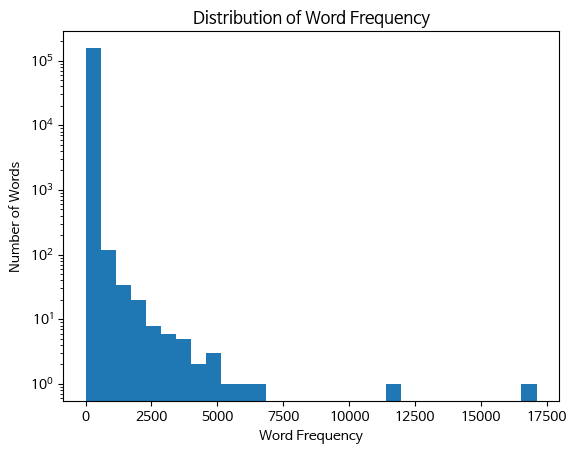

In [26]:
from collections import Counter

# 데이터에서 단어들을 토큰화하여 리스트로 생성
tokenized_words = [word for sentence in X_train for word in sentence.split()]

# 단어들의 빈도를 세고 상위 빈도 단어를 출력
word_counts = Counter(tokenized_words)
print('전체 샘플의 수 : {}'.format(len(X_train)))
print('단어 집합의 크기 : {}'.format(len(word_counts)))

# 시각화
word_freq = list(word_counts.values())

plt.hist(word_freq, bins=30, log=True)
plt.xlabel('Word Frequency')
plt.ylabel('Number of Words')
plt.title('Distribution of Word Frequency')
plt.show()

In [27]:
# 단어를 입력하면 빈도수 리턴
# 단어를 키(key)로, 단어에 대한 빈도수가 값(value)으로 저장
word_counts['너무']

17108

토큰화 적용

In [28]:
token = Tokenizer(num_words=10000) # 데이터에서 가장 빈도가 높은 상위 num_words개의 단어만을 사용하여 토큰화
token.fit_on_texts(X_train)
len(token.word_index)

102317

## 패딩
길이가 다른 문장들을 모두 동일한 길이로 바꿔준다
- https://wikidocs.net/64517

In [29]:
X_train

22607    과가 없어지고 과와 통합된대. 내가 다니던 과가 없어져서 당황스러워.추억이 없어지는...
40179    내게 딸이 둘 있어. 첫째는 시집가서 아들만 둘이고 둘째 딸은 공부만 하고 시집갈 ...
3634     다이어트해서 십 킬로그램이나 체중을 줄였어.회사도 가고 아이도 봐야 하고 집안일까지...
23436    남편이 이혼할 위자료를 주지 않으려고 변호사를 고용했어.어떻게 그럴 수가 있지? 너...
54144      퇴직금이 정산 돼서 나왔어.나이가 많지만 아픈데도 없고 퇴직금도 나왔으니 너무 기뻐.
                               ...                        
9604     옆 동료가 과로로 회사에서 쓰러졌어.일이 많긴 하지. 일은 없으니까 나도 그렇게 될...
3585     어려서부터 내성적이고 낯가림이 심한 성격이라 친구가 별로 없었어.괜찮을 때도 있지만...
25415    재산이 아무리 많아도 제 몸 못 가누면 무슨 소용이야.조금만 아파도 힘든데 몸도 못...
30565                  어떡하면 좋지?친구가 아무래도 따돌림을 당하는거 같아. 어쩌지?
42506    치질 때문에 매운 걸 못 먹는데 여자친구가 매운 걸 먹고 싶어 해서 큰일이야.여태 ...
Name: text, Length: 47532, dtype: object

In [30]:
X_train_enc = token.texts_to_sequences(X_train) # 토크나이저를 사용해 입력 텍스트 시퀀스 변환
X_train_enc

[[8411, 2871, 2, 1340, 8411, 3387, 229, 6331, 4521, 43, 767, 4406, 431, 2604],
 [365,
  170,
  866,
  25,
  7194,
  6591,
  1560,
  2538,
  11,
  198,
  31,
  192,
  63,
  6077,
  6591,
  1148,
  5273,
  655,
  241,
  3205,
  790,
  55,
  4301,
  83,
  983,
  1593,
  2,
  39,
  11,
  6591,
  170,
  1541,
  66,
  31,
  1,
  386,
  337,
  1277,
  1,
  3206,
  256,
  192,
  206],
 [768,
  3533,
  213,
  2973,
  995,
  11,
  39,
  235,
  95,
  1325,
  4302,
  242,
  5,
  42,
  858,
  2008,
  105,
  6592,
  146,
  3,
  95,
  5664,
  4,
  391,
  633,
  28,
  297,
  184],
 [69,
  5860,
  618,
  1523,
  7195,
  21,
  384,
  131,
  238,
  1,
  52,
  26,
  29,
  7195,
  217,
  4522,
  9],
 [5107, 284, 705, 78, 5274, 4523, 93, 1, 109],
 [40,
  332,
  526,
  1831,
  172,
  10,
  230,
  172,
  726,
  441,
  6,
  456,
  62,
  634,
  650,
  5108,
  10,
  9,
  6593,
  311,
  7578,
  3251,
  4524],
 [429,
  1288,
  233,
  50,
  112,
  248,
  2351,
  270,
  1647,
  429,
  2823,
  429,
  2685,
  28,
  18

71
20.12012959690314


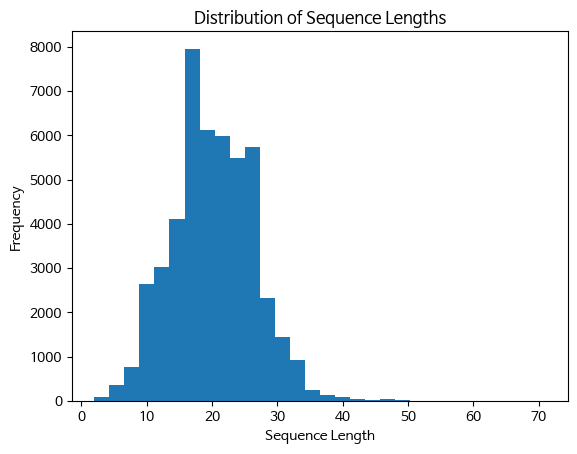

In [31]:
# 각 시퀀스의 길이를 측정
import matplotlib.pyplot as plt

# 가장 긴 문장
print(max(len(x) for x in X_train_enc))

# 평균 문장
print(np.mean([len(x) for x in X_train_enc]))

# 각 시퀀스의 길이를 측정
sequence_lengths = [len(seq) for seq in X_train_enc]

# 히스토그램으로 시각화
plt.hist(sequence_lengths, bins=30)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Sequence Lengths')
plt.show()

In [32]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

max_len = 30
below_threshold_len(max_len, X_train_enc)

전체 샘플 중 길이가 30 이하인 샘플의 비율: 95.58613144828747


In [33]:
# 모든 시퀀스의 길이가 동일해지도록 차원 축소 적용
X_train = sequence.pad_sequences(X_train_enc, maxlen=30, padding='post')
X_train

array([[8411, 2871,    2, ...,    0,    0,    0],
       [6077, 6591, 1148, ...,  256,  192,  206],
       [ 768, 3533,  213, ...,  184,    0,    0],
       ...,
       [3918,  459, 2204, ...,    0,    0,    0],
       [3162,  168,   24, ...,    0,    0,    0],
       [8722,   42,    8, ...,  280, 3678,   14]], dtype=int32)

In [34]:
vocab_size = len(token.word_index) + 1 # 단어 집합의 크기에는 패딩을 위한 토큰을 추가하기 위해 1 더함
vocab_size

102318

# 4) 모델 적합

In [35]:
!pip install keras_tuner

In [37]:
import IPython
import keras_tuner as kt
from tensorflow import keras

tf.random.set_seed(33)

def model_builder(hp):

    output_size = 6
    hp_units = hp.Int('units', min_value = 40, max_value = 96, step = 8)
    hp_units1 = hp.Int('units1', min_value = 40, max_value = 96, step = 8)
    hp_units2 = hp.Int('units2', min_value = 40, max_value = 96, step = 8)
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2])

    lstm_layer = keras.layers.LSTM(hp_units,
                                   activation='tanh',
                                   recurrent_activation='sigmoid')

    model = keras.models.Sequential(
        [
            keras.layers.Input(shape=(30,)),
            keras.layers.Embedding(vocab_size, 64, input_length=30),
            lstm_layer,
            keras.layers.BatchNormalization(),
            keras.layers.Dense(hp_units1, activation='relu'),
            keras.layers.Dense(hp_units2, activation='relu'),
            keras.layers.Dense(output_size, activation='softmax'),
        ]
    )

    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  metrics=['accuracy'])
    return model

# 하이퍼파라미터 검색
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy',
                     max_epochs = 100,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'kt9_LSTM_result')

class ClearTrainingOutput(tf.keras.callbacks.Callback):
    def on_train_end(*args, **kwargs):
        IPython.display.clear_output(wait = True)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                           min_delta=0,
                                           patience=5,
                                           verbose=1)

checkpoint_filepath = "best_a.hdf5"
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
    mode='auto',
    save_freq='epoch',
    options=None)

tuner.search(X_train, y_train,
             epochs=100,
             batch_size=800,
             callbacks=[ClearTrainingOutput(), early_stop, save_best],
             validation_split=0.15)

Trial 102 Complete [00h 00m 01s]

Best val_accuracy So Far: 0.5915848612785339
Total elapsed time: 00h 50m 56s

Search: Running Trial #103

Value             |Best Value So Far |Hyperparameter
48                |56                |units
48                |64                |units1
48                |56                |units2
0.01              |0.01              |learning_rate
4                 |2                 |tuner/epochs
2                 |0                 |tuner/initial_epoch
4                 |4                 |tuner/bracket
1                 |0                 |tuner/round
0075              |None              |tuner/trial_id



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 164, in _t

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "/usr/local/lib/python3.10/dist-packages/keras_tuner/src/tuners/hyperband.py", line 438, in _build_hypermodel
    model.load_weights(self._get_checkpoint_fname(trial_id))
  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/usr/local/lib/python3.10/dist-packages/tensorflow/python/ops/resource_variable_ops.py", line 785, in _restore_from_tensors
    raise ValueError(
ValueError: Received incompatible tensor with shape (102385, 64) when attempting to restore variable with shape (102318, 64) and name embedding/embeddings:0.


In [38]:
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
best_hps

In [39]:
model = tuner.hypermodel.build(best_hps)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 30, 64)            6548352   
                                                                 
 lstm_1 (LSTM)               (None, 56)                27104     
                                                                 
 batch_normalization_1 (Bat  (None, 56)                224       
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 64)                3648      
                                                                 
 dense_4 (Dense)             (None, 56)                3640      
                                                                 
 dense_5 (Dense)             (None, 6)                 342       
                                                      

- Embedding 층: 입력 텍스트를 임베딩하여 밀집 벡터로 변환합니다. 이 층은 입력 시퀀스의 각 단어를 64차원의 임베딩 벡터로 매핑합니다.
- LSTM 층: 임베딩된 단어 벡터의 시퀀스를 입력으로 받아 LSTM(Long Short-Term Memory) 알고리즘을 사용하여 시퀀스 정보를 추출합니다. LSTM 층은 56개의 유닛을 가지고 있습니다.
- BatchNormalization 층: 배치 정규화를 수행하여 모델의 학습을 안정화시킵니다.
- Dense 층 (첫 번째): 64개의 유닛과 ReLU 활성화 함수를 사용하여 완전 연결층을 정의합니다.
- Dense 층 (두 번째): 56개의 유닛과 ReLU 활성화 함수를 사용하여 또 다른 완전 연결층을 정의합니다.
- Dense 층 (출력): 최종 출력층으로, 6개의 클래스에 대한 확률을 출력하기 위해 소프트맥스 활성화 함수를 사용합니다.

In [40]:
# Model fit with the best model
model.fit(X_train, y_train,
          epochs=100,
          batch_size=600,
          callbacks=[early_stop, save_best],
          validation_split=0.15)

Epoch 1/100
68/68 [==============================] - ETA: 0s - loss: 1.4841 - accuracy: 0.3472
Epoch 1: val_accuracy improved from -inf to 0.40337, saving model to best_a.hdf5
68/68 [==============================] - 24s 303ms/step - loss: 1.4841 - accuracy: 0.3472 - val_loss: 1.6070 - val_accuracy: 0.4034
Epoch 2/100
68/68 [==============================] - ETA: 0s - loss: 1.0424 - accuracy: 0.6105
Epoch 2: val_accuracy improved from 0.40337 to 0.47195, saving model to best_a.hdf5
68/68 [==============================] - 8s 113ms/step - loss: 1.0424 - accuracy: 0.6105 - val_loss: 1.4652 - val_accuracy: 0.4719
Epoch 3/100
68/68 [==============================] - ETA: 0s - loss: 0.8583 - accuracy: 0.6905
Epoch 3: val_accuracy improved from 0.47195 to 0.55161, saving model to best_a.hdf5
68/68 [==============================] - 6s 90ms/step - loss: 0.8583 - accuracy: 0.6905 - val_loss: 1.3400 - val_accuracy: 0.5516
Epoch 4/100
68/68 [==============================] - ETA: 0s - loss: 0.71

In [41]:
model.load_weights(checkpoint_filepath)

# 5) 모델 test

In [58]:
X_test_enc = token.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(X_test_enc, maxlen=30, padding='post')
y_test = tf.one_hot(y_test['target'], 6)

In [59]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)

263/263 [==============================] - 1s 5ms/step - loss: 1.1717 - accuracy: 0.5993


In [69]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred))

263/263 [==============================] - 1s 4ms/step
              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1398
           1       0.54      0.59      0.56      1398
           2       0.54      0.55      0.54      1398
           3       0.48      0.68      0.56      1398
           4       0.64      0.34      0.44      1398
           5       0.62      0.53      0.57      1398

    accuracy                           0.60      8388
   macro avg       0.61      0.60      0.59      8388
weighted avg       0.61      0.60      0.59      8388



- Precision: Positive로 예측한 것 중에 실제 Positive인 비율
- Recall: 실제 Positive 중에 모델이 Positive로 예측한 비율
- F1-score: Precision과 Recall의 조화평균으로, 불균형한 데이터셋에서 모델의 성능을 평가하는 데 유용
- Accuracy: 전체 예측 중 올바르게 분류된 비율


<행복>은 비교적 높지만 클래스4인 <상처>는 잘 분류가 되지 않음

In [91]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from konlpy.tag import Okt

index_to_tag = {0 : '기쁨', 1 : '당황', 2 : '분노', 3 : '불안', 4 : '상처', 5 : '슬픔'}

def predict(text, model, tokenizer, index_to_tag, max_seq_length):
    okt = Okt()
    # Tokenize the input text
    tokens = okt.morphs(text) # 토큰화
    token_indices = tokenizer.texts_to_sequences([tokens])  # Convert tokens to indices

    # Pad sequences to have same length as training data
    token_indices = pad_sequences(token_indices, maxlen=max_seq_length, padding='post')

    # Pass the input tensor through the model
    logits = model.predict(token_indices)  # Get model predictions

    # Get the predicted class index
    predicted_index = logits.argmax(axis=1)[0]

    # Convert the predicted index to its corresponding tag
    predicted_tag = index_to_tag[predicted_index]

    return predicted_tag

In [90]:
# Test the function with the given input text
test_input = "오늘은 아침에 일어나자마자 흐린 날씨에 기분이 우울했어요. 하지만 아침 식사를 하고 밖으로 나가니 산뜻한 공기와 바람이 저를 맞이해 기분이 좋아졌어요. \
                머릿속의 부담스러운 생각들이 사라지고, 마음이 가벼워져서 산책을 즐겼어요. \
                오후에는 친구들과의 만남이 있어서 설레고 기대되는 마음으로 하루를 마무리했어요. \
                집으로 돌아와서도 그 행복한 기분이 계속되어 좋은 꿈을 꾸고 있어요."
predicted_tag = predict(test_input, model, token, index_to_tag, 30)
print("Predicted Emotion:", predicted_tag)

1/1 [==============================] - 0s 104ms/step
Predicted Emotion: 기쁨


In [103]:
test_input = "오늘은 마음이 무거워서 힘든 하루였어요. " \
              "뱃속의 작은 생명이 나에게 큰 기쁨을 주고 있지만, 가끔은 불안과 슬픔이 뒤섞여요. 오늘은 그런 날이었어요. " \
              "아이를 향한 사랑과 동시에 부담스러운 책임감이 마음을 무겁게 만들었어요. " \
              "또한, 몸이 불편해서 힘들었고, 아이가 건강하게 태어날까봐 걱정이 많았어요. " \
              "그런데도 아이가 나에게서 받는 사랑과 행복은 모든 것을 잊게 해주는 듯해요. 아이와 함께하는 순간들은 저에게 힘을 주고, 위로가 되어요. " \
              "오늘은 이런 마음을 담아 노래를 듣고 편안한 휴식을 취했어요. 내일은 더 행복한 하루가 될 거라고 믿어요."
predicted_tag = predict(test_input, model, token, index_to_tag, 30)
print("Predicted Emotion:", predicted_tag)

1/1 [==============================] - 0s 21ms/step
Predicted Emotion: 슬픔


In [108]:
def predict_with_prob(text, model, tokenizer, index_to_tag, max_seq_length):
    okt = Okt()
    # Tokenize the input text
    tokens = okt.morphs(text) # 토큰화
    token_indices = tokenizer.texts_to_sequences([tokens])  # Convert tokens to indices

    # Pad sequences to have same length as training data
    token_indices = pad_sequences(token_indices, maxlen=max_seq_length, padding='post')

    # Pass the input tensor through the model
    logits = model.predict(token_indices)  # Get model predictions

    # Convert logits to probabilities
    probabilities = tf.nn.softmax(logits)

    # Get the predicted tag and probability for each class
    predicted_results = {}
    for i, (emotion, tag) in enumerate(index_to_tag.items()):
        predicted_results[tag] = probabilities[0][i].numpy()

    return predicted_results

In [110]:
# 예측 함수 호출
test_input = "어제부터 먹고 싶었던 아이스크림을 꾹 참다가 퇴근하고 샀다." \
            "콩콩이도 맛있게 먹고 싶었겠지? 곧 콩콩이를 볼 생각에 너무나도 행복하고 설렌다."

predicted_results = predict_with_prob(test_input, model, token, index_to_tag, 30)
for tag, prob in predicted_results.items():
    print(f"{tag}: {prob * 100:.2f}%")

1/1 [==============================] - 0s 53ms/step
기쁨: 21.22%
당황: 15.37%
분노: 15.59%
불안: 16.27%
상처: 15.52%
슬픔: 16.03%
